### Transformer only encoder

In [1]:
import os, glob, time, math, random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from utils.utils import TimeEstimator
from torch.cuda.amp import autocast, GradScaler

# Enable cuDNN autotuner for best algorithm selection
torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# %% [markdown]
# ## Environment Definition (TSPEnv)

class TSPEnv:
    def __init__(self, problem_size):
        self.problem_size = problem_size
        self.pomo_size = problem_size

    def load_problems(self, batch_size, aug_factor=1):
        self.pomo_size = self.problem_size
        inst_dir = f'data/TSP{self.problem_size}/instances'
        files = glob.glob(f'{inst_dir}/*.npz')
        if files:
            chosen = (random.sample(files, batch_size)
                      if batch_size <= len(files)
                      else random.choices(files, k=batch_size))
            coords = [torch.from_numpy(np.load(f)['coords']).float()
                      for f in chosen]
            self.problems = torch.stack(coords, 0).to(device)
        else:
            from TSProblemDef import get_random_problems
            self.problems = get_random_problems(batch_size, self.problem_size).to(device)

        if aug_factor == 8:
            from TSProblemDef import augment_xy_data_by_8_fold
            self.problems = augment_xy_data_by_8_fold(self.problems).to(device)

        self.batch_size = self.problems.size(0)
        B, P = self.batch_size, self.pomo_size
        self.BATCH_IDX = torch.arange(B, device=device)[:, None].expand(B, P)
        self.POMO_IDX  = torch.arange(P, device=device)[None, :].expand(B, P)

    def reset(self):
        self.selected_count = 0
        self.selected_node_list = torch.zeros(
            (self.batch_size, self.pomo_size, 0),
            dtype=torch.long, device=device
        )
        mask = torch.zeros(
            (self.batch_size, self.pomo_size, self.problem_size),
            dtype=torch.float, device=device
        )
        return (self.problems, self.BATCH_IDX, self.POMO_IDX, mask), None, False

    def step(self, state_sel, selected):
        problems, B_idx, P_idx, mask = state_sel
        self.selected_count += 1
        self.selected_node_list = torch.cat(
            (self.selected_node_list, selected[:, :, None]), dim=2
        )
        mask[B_idx, P_idx, selected] = float('-inf')
        done = (self.selected_count == self.problem_size)
        reward = -self._get_travel_distance() if done else None
        return (problems, B_idx, P_idx, mask), reward, done

    def _get_travel_distance(self):
        coords = self.problems
        B, P, N = self.batch_size, self.pomo_size, self.problem_size
        order = self.selected_node_list.unsqueeze(3).expand(B, P, N, 2)
        seq   = coords[:, None, :, :].expand(B, P, N, 2)
        ordered = seq.gather(2, order)
        rolled  = ordered.roll(dims=2, shifts=-1)
        seg = ((ordered - rolled)**2).sum(3).sqrt()
        return seg.sum(2)

# %% [markdown]
# ## Transformer Encoder Definition (TSP_Encoder)

def reshape_by_heads(x, head_num):
    B, n, _ = x.size()
    return x.view(B, n, head_num, -1).transpose(1, 2)

class AddNorm(nn.Module):
    def __init__(self, emb):
        super().__init__()
        self.norm = nn.InstanceNorm1d(emb, affine=True)
    def forward(self, x, sub):
        return self.norm((x + sub).transpose(1,2)).transpose(1,2)

class FeedForward(nn.Module):
    def __init__(self, emb, hid):
        super().__init__()
        self.w1 = nn.Linear(emb, hid)
        self.w2 = nn.Linear(hid, emb)
    def forward(self, x):
        return self.w2(F.relu(self.w1(x)))

class TSP_Encoder(nn.Module):
    def __init__(self, embedding_dim, encoder_layer_num,
                 head_num, qkv_dim, ff_hidden_dim, **_):
        super().__init__()
        self.embed = nn.Linear(2, embedding_dim)
        self.head_num = head_num
        layers = []
        for _ in range(encoder_layer_num):
            layers.append(nn.ModuleDict({
                'Wq':      nn.Linear(embedding_dim, head_num*qkv_dim, bias=False),
                'Wk':      nn.Linear(embedding_dim, head_num*qkv_dim, bias=False),
                'Wv':      nn.Linear(embedding_dim, head_num*qkv_dim, bias=False),
                'combine': nn.Linear(head_num*qkv_dim, embedding_dim),
                'an1':     AddNorm(embedding_dim),
                'ff':      FeedForward(embedding_dim, ff_hidden_dim),
                'an2':     AddNorm(embedding_dim)
            }))
        self.layers = nn.ModuleList(layers)

    def forward(self, coords):
        x = self.embed(coords)
        for l in self.layers:
            q = reshape_by_heads(l['Wq'](x), self.head_num)
            k = reshape_by_heads(l['Wk'](x), self.head_num)
            v = reshape_by_heads(l['Wv'](x), self.head_num)
            d = q.size(-1)
            scores = torch.matmul(q, k.transpose(-2,-1)) / math.sqrt(d)
            att = torch.matmul(F.softmax(scores, dim=-1), v)
            att = att.transpose(1,2).reshape(x.size(0), x.size(1), -1)
            x = l['an1'](x, l['combine'](att))
            x = l['an2'](x, l['ff'](x))
        return x

# %% [markdown]
# ## Loaders for Homework & NPZ Instances

def load_homework_instances(txt_path):
    insts = []
    for ln in open(txt_path).read().strip().splitlines():
        tok = ln.split()
        i   = tok.index('output')
        f   = list(map(float, tok[:i]))
        N   = len(f)//2
        coords = torch.tensor(f, dtype=torch.float).view(N,2)
        tour   = [int(x)-1 for x in tok[i+1:i+1+N]]
        insts.append((coords, tour))
    return insts

def load_npz_instances(N, cnt):
    files = glob.glob(f'data/TSP{N}/instances/*.npz')
    if not files:
        raise FileNotFoundError(f"No NPZ for TSP{N}")
    chosen = (random.sample(files, cnt)
              if cnt <= len(files) else random.choices(files, k=cnt))
    data = [torch.from_numpy(np.load(f)['coords']).float() for f in chosen]
    return torch.stack(data,0)

# %% [markdown]
# ## Hyperparameters & Policy Head

params = {
    'embedding_dim':      128,
    'encoder_layer_num':   3,
    'head_num':            8,
    'qkv_dim':            64,
    'ff_hidden_dim':     512,
    'sqrt_embedding_dim': math.sqrt(128),
    'logit_clipping':     10.0
}

curriculum = [
    {'sizes':[20],    'steps':10000},
    {'sizes':[50], 'steps':10000},
]

train_params = {
    'batch_size':   512,
    'log_interval': 1000,
}

opt_params   = {'lr':1e-4, 'betas':(0.9,0.999), 'weight_decay':1e-4}
sched_params = {'milestones':[20000,50000], 'gamma':0.5}

def policy_head(q, emb, mask):
    lm = torch.matmul(q, emb.transpose(1,2)) / params['sqrt_embedding_dim']
    lm = params['logit_clipping'] * torch.tanh(lm) + mask
    return F.softmax(lm, dim=-1)

# %% [markdown]
# ## Training & Intermediate Evaluation (with AMP & DataParallel)

# Prepare
homework = load_homework_instances('data/homework/hw_2_tsp_20.txt')

# Initialize environment & model
env = TSPEnv(problem_size=curriculum[0]['sizes'][0])
enc = TSP_Encoder(**params).to(device)
enc = nn.DataParallel(enc)          # Multi-GPU wrap
scaler = GradScaler()               # AMP scaler

opt   = torch.optim.Adam(enc.parameters(), **opt_params)
sched = torch.optim.lr_scheduler.MultiStepLR(opt, **sched_params)
timer = TimeEstimator()

steps, loss_log, dist_log = [], [], []
global_step = 0
start_time  = time.time()

for stage_idx, stage in enumerate(curriculum, 1):
    print(f"\n=== Stage {stage_idx}: sizes={stage['sizes']} steps={stage['steps']} ===")
    for _ in range(stage['steps']):
        global_step += 1

        # 1) Load batch
        sz = random.choice(stage['sizes'])
        env.problem_size = sz
        env.load_problems(train_params['batch_size'])
        (ps, Bi, Pi, mask), _, _ = env.reset()

        B = ps.size(0); P = sz; D = params['embedding_dim']

        # 2) Mixed-precision forward
        logs = []
        done = False
        with autocast():
            emb = enc(ps)  # (B, N, D)

            # initial query
            idx0 = torch.arange(P, device=device)[None,:].expand(B,P)
            q    = emb.gather(1, idx0[:,:,None].expand(B,P,D))

            # rollout
            while not done:
                pr = policy_head(q, emb, mask)  # (B,P,N)
                sel = pr.reshape(B*P, sz).multinomial(1).view(B,P)
                logs.append(torch.log(pr[torch.arange(B)[:,None],
                                         torch.arange(P)[None,:],
                                         sel]))
                (ps, Bi, Pi, mask), r, done = env.step((ps, Bi, Pi, mask), sel)
                q = emb.gather(1, sel[:,:,None].expand(B,P,D))

            r    = r.to(device)
            adv  = r - r.mean(dim=1, keepdim=True)
            logp = torch.stack(logs, dim=2).sum(dim=2)
            loss = -(adv * logp).mean()

        # 3) AMP backward + step
        opt.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        sched.step()

        # 4) Logging
        if global_step == 1 or global_step % train_params['log_interval'] == 0:
            avg_dist = -r.max(dim=1)[0].mean().item()
            elapsed  = time.time() - start_time
            print(f"Step {global_step:6d} | Size {sz:2d} | "
                  f"Loss {loss.item():.4f} | Dist {avg_dist:.4f} | Elap {elapsed:.1f}s")
            steps.append(global_step)
            loss_log.append(loss.item())
            dist_log.append(avg_dist)

    # Intermediate Evaluation (unchanged)
    print(f"\n--- Stage {stage_idx} Intermediate Eval ---")
    for i, (coord, tour) in enumerate(homework, 1):
        N_hw = coord.size(0)
        env_eval = TSPEnv(problem_size=N_hw)
        env_eval.problems   = coord.unsqueeze(0).to(device)
        env_eval.batch_size = 1
        env_eval.BATCH_IDX  = torch.zeros((1, N_hw), dtype=torch.long, device=device)
        env_eval.POMO_IDX   = torch.arange(N_hw, device=device)[None, :]

        (ps, Bi, Pi, mask), _, _ = env_eval.reset()
        emb_hw = enc(ps)
        D = emb_hw.size(2)
        q_hw = emb_hw.gather(1,
                   env_eval.POMO_IDX[:,:,None].expand(1, N_hw, D))
        mask_hw = torch.zeros((1, N_hw, N_hw), device=device)

        done = False
        while not done:
            pr_hw  = policy_head(q_hw, emb_hw, mask_hw)
            sel_hw = pr_hw.argmax(dim=2)
            (ps, Bi, Pi, mask_hw), r_hw, done = env_eval.step(
                (ps, Bi, Pi, mask_hw), sel_hw)
            q_hw = emb_hw.gather(1,
                      sel_hw[:,:,None].expand(1, N_hw, D))

        comp_dist = -r_hw.max().item()
        arr       = coord.cpu().numpy()
        opt_dist  = sum(np.linalg.norm(arr[tour[j]] - arr[tour[(j+1)%N_hw]])
                        for j in range(N_hw))
        gap = (comp_dist - opt_dist) / opt_dist * 100
        print(f"Inst {i}: Opt={opt_dist:.4f}, Comp={comp_dist:.4f}, Gap={gap:.2f}%")

Using device: cuda


C:\Users\oem\AppData\Local\Temp\ipykernel_25652\2499315783.py:203: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()               # AMP scaler



=== Stage 1: sizes=[20] steps=10000 ===


C:\Users\oem\AppData\Local\Temp\ipykernel_25652\2499315783.py:229: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\oem\AppData\Roaming\Python\Python311\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")


Step      1 | Size 20 | Loss -0.2096 | Dist 5.7002 | Elap 8.0s
Step   1000 | Size 20 | Loss -0.5742 | Dist 3.9138 | Elap 858.5s
Step   2000 | Size 20 | Loss -0.5181 | Dist 3.9182 | Elap 1300.5s
Step   3000 | Size 20 | Loss -0.4836 | Dist 3.9248 | Elap 1749.5s
Step   4000 | Size 20 | Loss -0.4529 | Dist 3.9192 | Elap 2195.1s
Step   5000 | Size 20 | Loss -0.4551 | Dist 3.9189 | Elap 2641.8s
Step   6000 | Size 20 | Loss -0.4299 | Dist 3.9063 | Elap 3084.3s
Step   7000 | Size 20 | Loss -0.3785 | Dist 3.9425 | Elap 3531.8s
Step   8000 | Size 20 | Loss -0.3506 | Dist 3.9178 | Elap 3980.8s
Step   9000 | Size 20 | Loss -0.3554 | Dist 3.9031 | Elap 4431.7s
Step  10000 | Size 20 | Loss -0.3418 | Dist 3.9345 | Elap 4875.9s

--- Stage 1 Intermediate Eval ---
Inst 1: Opt=3.3478, Comp=3.4940, Gap=4.37%
Inst 2: Opt=4.1313, Comp=4.1537, Gap=0.54%
Inst 3: Opt=4.4684, Comp=4.6232, Gap=3.46%
Inst 4: Opt=3.8637, Comp=3.8637, Gap=0.00%
Inst 5: Opt=4.1212, Comp=4.2743, Gap=3.71%

=== Stage 2: sizes=[50] ste

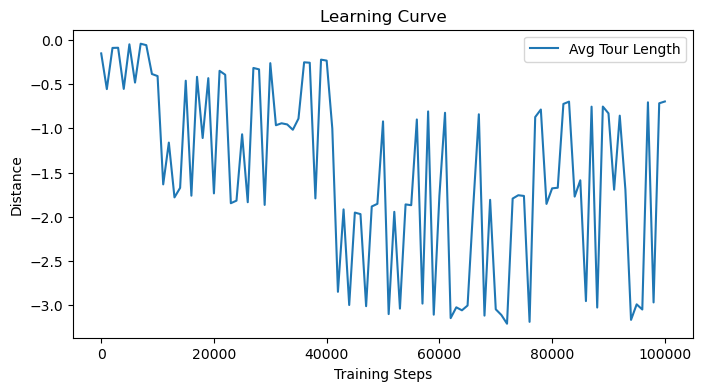

In [18]:
plt.figure(figsize=(8,4))
plt.plot(steps, loss_log, label='Avg Tour Length')
plt.xlabel('Training Steps')
plt.ylabel('Distance')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [2]:
for N, cnt in [(20, 100), (50, 100)]:
    test_txt = f"data/test/tsp{N}_test.txt"
    if os.path.exists(test_txt):
        samples = load_homework_instances(test_txt)
        gaps = []
        for coords, opt_tour in samples:
            # env_eval 초기화
            env_eval = TSPEnv(problem_size=N)
            env_eval.problems     = coords.unsqueeze(0).to(device)
            env_eval.batch_size   = 1
            env_eval.BATCH_IDX    = torch.zeros((1, N), dtype=torch.long, device=device)
            env_eval.POMO_IDX     = torch.arange(N, device=device)[None, :]

            (ps, Bi, Pi, mask), _, _ = env_eval.reset()
            emb_hw = enc(ps)
            q_hw   = emb_hw.gather(
                          1,
                          env_eval.POMO_IDX[:, :, None]
                              .expand(1, N, D)
                      )
            mask_hw = torch.zeros((1, N, N), device=device)

            done = False
            while not done:
                pr_hw  = policy_head(q_hw, emb_hw, mask_hw)
                sel_hw = pr_hw.argmax(dim=2)
                (ps, Bi, Pi, mask_hw), r_hw, done = env_eval.step(
                    (ps, Bi, Pi, mask_hw), sel_hw
                )
                q_hw = emb_hw.gather(
                           1,
                           sel_hw[:, :, None]
                               .expand(1, N, D)
                       )
            comp_dist = -r_hw.max().item()

            # optimal tour 거리 계산
            arr = coords.cpu().numpy()
            opt_dist = sum(
                np.linalg.norm(arr[opt_tour[j]] - arr[opt_tour[(j+1) % N]])
                for j in range(N)
            )

            # gap 계산
            gaps.append((comp_dist - opt_dist) / opt_dist * 100)

        avg_gap = float(np.mean(gaps))
        print(f"TSP{N} avg gap (TXT): {avg_gap:.2f}%")
    else:
        print(f"▶ Missing test file: {test_txt}, skipping gap calculation.")

TSP20 avg gap (TXT): 5.88%
TSP50 avg gap (TXT): 5.87%


### Transformer full logic

In [1]:
# %% [markdown]
# # Imports & Device Setup

import os, glob, time, math, random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from utils.utils import TimeEstimator
from torch.cuda.amp import autocast, GradScaler

# cuDNN autotuner 활성화
torch.backends.cudnn.benchmark = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda:0


In [2]:
# %% [markdown]
# ## Environment Definition (TSPEnv)

class TSPEnv:
    def __init__(self, problem_size):
        self.problem_size = problem_size
        self.pomo_size = problem_size  # POMO 크기 = 도시 수

    def load_problems(self, batch_size, aug_factor=1):
        # 항상 problem_size == pomo_size 유지
        self.pomo_size = self.problem_size
        inst_dir = f"data/TSP{self.problem_size}/instances"
        files = glob.glob(f"{inst_dir}/*.npz")
        if files:
            chosen = (random.sample(files, batch_size)
                      if batch_size <= len(files)
                      else random.choices(files, k=batch_size))
            coords = [torch.from_numpy(np.load(f)["coords"]).float() for f in chosen]
            self.problems = torch.stack(coords, 0).to(device)  # (B, N, 2)
        else:
            # NPZ 파일이 없으면 랜덤 문제 생성
            from TSProblemDef import get_random_problems
            self.problems = get_random_problems(batch_size, self.problem_size).to(device)

        if aug_factor == 8:
            from TSProblemDef import augment_xy_data_by_8_fold
            self.problems = augment_xy_data_by_8_fold(self.problems).to(device)

        self.batch_size = self.problems.size(0)
        B, P = self.batch_size, self.pomo_size
        self.BATCH_IDX = torch.arange(B, device=device)[:, None].expand(B, P)
        self.POMO_IDX  = torch.arange(P, device=device)[None, :].expand(B, P)

    def reset(self):
        self.selected_count = 0
        self.selected_node_list = torch.zeros(
            (self.batch_size, self.pomo_size, 0),
            dtype=torch.long, device=device
        )
        mask = torch.zeros(
            (self.batch_size, self.pomo_size, self.problem_size),
            dtype=torch.float, device=device
        )
        # state는 (problems, BATCH_IDX, POMO_IDX, mask)
        return (self.problems, self.BATCH_IDX, self.POMO_IDX, mask), None, False

    def pre_step(self):
        # 첫 스텝: reward=None, done=False 그대로 반환
        return (self.problems, self.BATCH_IDX, self.POMO_IDX,
                torch.zeros((self.batch_size, self.pomo_size, self.problem_size),
                            dtype=torch.float, device=device)), None, False

    def step(self, state_sel, selected):
        (problems, B_idx, P_idx, mask) = state_sel
        self.selected_count += 1

        # 선택한 도시 기록
        self.selected_node_list = torch.cat(
            (self.selected_node_list, selected[:, :, None]), dim=2
        )
        # 마스크 업데이트: 이미 방문한 도시에 -inf
        mask[B_idx, P_idx, selected] = float("-inf")

        done = (self.selected_count == self.problem_size)
        reward = -self._get_travel_distance() if done else None
        return (problems, B_idx, P_idx, mask), reward, done

    def _get_travel_distance(self):
        coords = self.problems  # (B, N, 2)
        B, P, N = self.batch_size, self.pomo_size, self.problem_size
        order = self.selected_node_list.unsqueeze(3).expand(B, P, N, 2)
        seq   = coords[:, None, :, :].expand(B, P, N, 2)
        ordered = seq.gather(2, order)            # (B, P, N, 2)
        rolled  = ordered.roll(dims=2, shifts=-1)  # (B, P, N, 2)
        seg = ((ordered - rolled) ** 2).sum(3).sqrt()  # (B, P, N)
        return seg.sum(2)  # (B, P)


In [4]:
# %% [markdown]
# ## Transformer Encoder & Decoder with Relative Position Embedding

def reshape_by_heads(x, head_num):
    B, n, _ = x.size()
    return x.view(B, n, head_num, -1).transpose(1, 2)

class AddNorm(nn.Module):
    def __init__(self, emb):
        super().__init__()
        self.norm = nn.InstanceNorm1d(emb, affine=True)
    def forward(self, x, sub):
        return self.norm((x + sub).transpose(1, 2)).transpose(1, 2)

class FeedForward(nn.Module):
    def __init__(self, emb, hid):
        super().__init__()
        self.w1 = nn.Linear(emb, hid)
        self.w2 = nn.Linear(hid, emb)
    def forward(self, x):
        return self.w2(F.relu(self.w1(x)))

class TSP_Encoder(nn.Module):
    def __init__(self, embedding_dim, encoder_layer_num,
                 head_num, qkv_dim, ff_hidden_dim, **_):
        super().__init__()
        self.embed = nn.Linear(2, embedding_dim)
        self.head_num = head_num
        # 상대 위치 임베딩을 위한 선형 투영
        self.rel_proj = nn.Linear(2, 1, bias=False)

        layers = []
        for _ in range(encoder_layer_num):
            layers.append(nn.ModuleDict({
                "Wq":      nn.Linear(embedding_dim, head_num * qkv_dim, bias=False),
                "Wk":      nn.Linear(embedding_dim, head_num * qkv_dim, bias=False),
                "Wv":      nn.Linear(embedding_dim, head_num * qkv_dim, bias=False),
                "combine": nn.Linear(head_num * qkv_dim, embedding_dim),
                "an1":     AddNorm(embedding_dim),
                "ff":      FeedForward(embedding_dim, ff_hidden_dim),
                "an2":     AddNorm(embedding_dim),
            }))
        self.layers = nn.ModuleList(layers)

    def forward(self, coords):
        """
        coords: (B, N, 2)
        returns: x_enc (B, N, D)
        """
        B, N, _ = coords.size()
        D = self.embed.out_features

        # 1) 노드 임베딩
        x = self.embed(coords)  # (B, N, D)

        # 2) 상대 위치 bias 계산
        delta = coords.unsqueeze(2) - coords.unsqueeze(1)  # (B, N, N, 2)
        rel_bias = self.rel_proj(delta).squeeze(-1)        # (B, N, N)

        # 3) Transformer 레이어
        for l in self.layers:
            q = reshape_by_heads(l["Wq"](x), self.head_num)  # (B, head, N, d)
            k = reshape_by_heads(l["Wk"](x), self.head_num)  # (B, head, N, d)
            v = reshape_by_heads(l["Wv"](x), self.head_num)  # (B, head, N, d)

            d = q.size(-1)
            scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d)  # (B, head, N, N)

            # 상대 위치 bias 추가
            scores = scores + rel_bias.unsqueeze(1)  # (B, head, N, N)

            weights = F.softmax(scores, dim=-1)  # (B, head, N, N)
            att = torch.matmul(weights, v)       # (B, head, N, d)

            att = att.transpose(1, 2).reshape(B, N, -1)  # (B, N, head*d)
            x = l["an1"](x, l["combine"](att))           # Add & Norm
            x = l["an2"](x, l["ff"](x))                  # Add & Norm

        return x  # (B, N, D)

class TSP_Decoder(nn.Module):
    def __init__(self, embedding_dim, head_num, qkv_dim, **_):
        super().__init__()
        self.head_num = head_num
        self.Wq_first = nn.Linear(embedding_dim, head_num * qkv_dim, bias=False)
        self.Wq_last  = nn.Linear(embedding_dim, head_num * qkv_dim, bias=False)
        self.Wk       = nn.Linear(embedding_dim, head_num * qkv_dim, bias=False)
        self.Wv       = nn.Linear(embedding_dim, head_num * qkv_dim, bias=False)
        self.combine  = nn.Linear(head_num * qkv_dim, embedding_dim)

        self.k = None
        self.v = None
        self.q_first = None
        self.single_head_key = None

    def set_kv(self, encoded_nodes):
        # encoded_nodes: (B, N, D)
        B, N, D = encoded_nodes.size()
        head_num = self.head_num
        self.k = reshape_by_heads(self.Wk(encoded_nodes), head_num)  # (B, head, N, d)
        self.v = reshape_by_heads(self.Wv(encoded_nodes), head_num)  # (B, head, N, d)
        self.single_head_key = encoded_nodes.transpose(1, 2)          # (B, D, N)

    def set_q1(self, encoded_first_node):
        # encoded_first_node: (B, P, D)
        head_num = self.head_num
        self.q_first = reshape_by_heads(
            self.Wq_first(encoded_first_node), head_num
        )  # (B, head, P, d)

    def forward(self, encoded_last_node, mask):
        """
        encoded_last_node: (B, P, D)
        mask: (B, P, N)
        returns: probs (B, P, N)
        """
        B, P, D = encoded_last_node.size()
        head_num = self.head_num
        d = D // head_num

        q_last = reshape_by_heads(self.Wq_last(encoded_last_node), head_num)  # (B, head, P, d)
        q = self.q_first + q_last  # (B, head, P, d)

        # Multi-Head Attention
        scores = torch.matmul(q, self.k.transpose(-2, -1)) / math.sqrt(d)  # (B, head, P, N)
        scores = scores + mask.unsqueeze(1).expand(B, head_num, P, -1)     # (B, head, P, N)
        weights = F.softmax(scores, dim=-1)                                # (B, head, P, N)
        out = torch.matmul(weights, self.v)                                # (B, head, P, d)

        out = out.transpose(1, 2).reshape(B, P, -1)  # (B, P, head*d)
        mh_out = self.combine(out)                  # (B, P, D)

        # Single-head for logits
        logits = torch.matmul(mh_out, self.single_head_key)  # (B, P, N)
        logits = logits / math.sqrt(d)
        logits = 10.0 * torch.tanh(logits)  # logit_clipping = 10.0
        logits = logits + mask
        probs = F.softmax(logits, dim=-1)    # (B, P, N)
        return probs


In [5]:
# %% [markdown]
# ## TSPModel with Encoder-Decoder (POMO)

class TSPModel(nn.Module):
    def __init__(self, **model_params):
        super().__init__()
        self.encoder = TSP_Encoder(**model_params)
        self.decoder = TSP_Decoder(**model_params)
        self.encoded_nodes = None  # (B, N, D)

    def pre_forward(self, reset_state):
        # reset_state[0] == problems: (B, N, 2)
        self.encoded_nodes = self.encoder(reset_state[0])  # (B, N, D)
        self.decoder.set_kv(self.encoded_nodes)

    def forward(self, state):
        """
        state = (problems, BATCH_IDX, POMO_IDX, mask)
        returns: selected (B, P), prob (B, P)
        """
        (_, B_idx, P_idx, mask) = state
        B, P = B_idx.size(0), B_idx.size(1)

        # 첫 스텝: mask가 모두 0일 때
        if mask is None or mask.sum().item() == 0:
            selected = torch.arange(P, device=device)[None, :].expand(B, P)
            prob = torch.ones((B, P), device=device)
            first_enc = self.encoded_nodes.gather(
                1, selected[:, :, None].expand(B, P, self.encoded_nodes.size(2))
            )  # (B, P, D)
            self.decoder.set_q1(first_enc)
            return selected, prob

        # 이후 스텝
        last_enc = self.encoded_nodes.gather(
            1, state[2][:, :, None].expand(B, P, self.encoded_nodes.size(2))
        )  # (B, P, D)
        probs = self.decoder(last_enc, mask)  # (B, P, N)

        if self.training:
            while True:
                flat = probs.reshape(B * P, -1)
                sel = flat.multinomial(1).view(B, P)
                p_sel = probs[B_idx, P_idx, sel]  # (B, P)
                if (p_sel != 0).all():
                    break
            return sel, p_sel
        else:
            sel = probs.argmax(dim=2)
            return sel, None


In [6]:
# %% [markdown]
# ## Loaders for Homework & NPZ Instances

def load_homework_instances(txt_path):
    insts = []
    for ln in open(txt_path).read().strip().splitlines():
        tok = ln.split()
        i = tok.index("output")
        coords = list(map(float, tok[:i]))
        N = len(coords) // 2
        coords = torch.tensor(coords, dtype=torch.float).view(N, 2)
        tour = [int(x) - 1 for x in tok[i + 1 : i + 1 + N]]
        insts.append((coords, tour))
    return insts

def load_npz_instances(N, cnt):
    files = glob.glob(f"data/TSP{N}/instances/*.npz")
    if not files:
        raise FileNotFoundError(f"No NPZ for TSP{N}")
    chosen = (random.sample(files, cnt)
              if cnt <= len(files) else random.choices(files, k=cnt))
    data = [torch.from_numpy(np.load(f)["coords"]).float() for f in chosen]
    return torch.stack(data, 0)


In [7]:
# %% [markdown]
# ## Hyperparameters & Policy Head

model_params = {
    "embedding_dim":     128,
    "encoder_layer_num": 3,
    "head_num":          8,
    "qkv_dim":           16,
    "ff_hidden_dim":     512,
}

curriculum = [
    {"sizes": [10, 20],      "steps": 10000},
    {"sizes": [20, 30, 40],  "steps": 30000},
    {"sizes": [30, 40, 50],  "steps": 60000},
]

train_params = {
    "batch_size":   512,
    "log_interval": 1000,
}

opt_params   = {"lr": 1e-4, "betas": (0.9, 0.999), "weight_decay": 1e-4}
sched_params = {"milestones": [20000, 50000], "gamma": 0.5}

def policy_head(q, emb, mask):
    """
    q:   (B, P, D)
    emb: (B, N, D)
    mask:(B, P, N)
    returns: probs (B, P, N)
    """
    lm = torch.matmul(q, emb.transpose(1, 2))  # (B, P, N)
    d = q.size(-1)
    lm = lm / math.sqrt(d)
    lm = 10.0 * torch.tanh(lm)   # logit_clipping=10.0
    lm = lm + mask
    return F.softmax(lm, dim=-1)


In [8]:
# %% [markdown]
# ## Training & Intermediate Evaluation (단일 GPU 기준)

# 1) 준비
homework = load_homework_instances("data/homework/hw_2_tsp_20.txt")
env      = TSPEnv(problem_size=curriculum[0]["sizes"][0])

# 모델 생성 (단일 GPU)
model  = TSPModel(**model_params).to(device)
scaler = GradScaler()

optimizer = torch.optim.Adam(model.parameters(), **opt_params)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, **sched_params)
timer     = TimeEstimator()

steps, loss_log, dist_log = [], [], []
global_step = 0
start_time  = time.time()

# 2) 커리큘럼 학습
for stage_idx, stage in enumerate(curriculum, 1):
    print(f"\n=== Stage {stage_idx}: sizes={stage['sizes']} steps={stage['steps']} ===")
    for _ in range(stage["steps"]):
        global_step += 1

        # 2.1) 배치 로드
        sz = random.choice(stage["sizes"])
        env.problem_size = sz
        env.load_problems(train_params["batch_size"])
        reset_state, _, _ = env.reset()  # (problems, B_idx, P_idx, mask)

        # 2.2) Encoder 사전 계산
        model.pre_forward(reset_state)

        # 2.3) POMO 롤아웃
        logs = []
        done = False
        state, _, _ = env.pre_step()

        while not done:
            with autocast():
                sel, prob = model(state)  # (B, P), (B, P)
            logs.append(torch.log(prob + 1e-9))
            state, reward, done = env.step(state, sel)

        # 2.4) 손실 계산 & 역전파
        r    = reward.to(device)                       # (B, P)
        adv  = r - r.mean(dim=1, keepdim=True)         # (B, P)
        logp = torch.stack(logs, dim=2).sum(dim=2)     # (B, P)
        loss = -(adv * logp).mean()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # 2.5) 로깅
        if global_step == 1 or global_step % train_params["log_interval"] == 0:
            avg_dist = -r.max(dim=1)[0].mean().item()
            elapsed  = time.time() - start_time
            print(f"Step {global_step:6d} | Size {sz:2d} | "
                  f"Loss {loss.item():.4f} | Dist {avg_dist:.4f} | Elap {elapsed:.1f}s")
            steps.append(global_step)
            loss_log.append(loss.item())
            dist_log.append(avg_dist)

    # 3) 스테이지별 중간 평가
    print(f"\n--- Stage {stage_idx} Intermediate Eval ---")
    for i, (coord, tour) in enumerate(homework, 1):
        N_hw = coord.size(0)
        env_eval = TSPEnv(problem_size=N_hw)
        env_eval.problems   = coord.unsqueeze(0).to(device)
        env_eval.batch_size = 1
        env_eval.BATCH_IDX  = torch.zeros((1, N_hw), dtype=torch.long, device=device)
        env_eval.POMO_IDX   = torch.arange(N_hw, device=device)[None, :]

        reset_state, _, _ = env_eval.reset()
        model.pre_forward(reset_state)

        state, _, _ = env_eval.pre_step()
        done = False
        while not done:
            sel_hw, _ = model(state)
            state, r_hw, done = env_eval.step(state, sel_hw)

        comp_dist = -r_hw.max().item()
        arr       = coord.cpu().numpy()
        opt_dist  = sum(
            np.linalg.norm(arr[tour[j]] - arr[tour[(j+1) % N_hw]])
            for j in range(N_hw)
        )
        gap = (comp_dist - opt_dist) / opt_dist * 100
        print(f"Inst {i}: Opt={opt_dist:.4f}, Comp={comp_dist:.4f}, Gap={gap:.2f}%")


C:\Users\oem\AppData\Local\Temp\ipykernel_18272\4156274537.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



=== Stage 1: sizes=[10, 20] steps=10000 ===


C:\Users\oem\AppData\Local\Temp\ipykernel_18272\4156274537.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Step      1 | Size 20 | Loss -2.2042 | Dist 7.1936 | Elap 7.9s
Step   1000 | Size 10 | Loss -0.0592 | Dist 2.8649 | Elap 1292.1s
Step   2000 | Size 20 | Loss -0.2395 | Dist 3.9398 | Elap 1903.2s
Step   3000 | Size 10 | Loss -0.0290 | Dist 2.8524 | Elap 2505.5s
Step   4000 | Size 20 | Loss -0.1131 | Dist 3.9097 | Elap 3107.7s
Step   5000 | Size 20 | Loss -0.0945 | Dist 3.8912 | Elap 3705.0s
Step   6000 | Size 20 | Loss -0.1096 | Dist 3.8825 | Elap 4327.6s
Step   7000 | Size 20 | Loss -0.0910 | Dist 3.8721 | Elap 4938.7s
Step   8000 | Size 20 | Loss -0.0737 | Dist 3.8662 | Elap 5541.1s
Step   9000 | Size 10 | Loss -0.0135 | Dist 2.8820 | Elap 6143.3s
Step  10000 | Size 20 | Loss -0.0876 | Dist 3.8673 | Elap 6745.8s

--- Stage 1 Intermediate Eval ---
Inst 1: Opt=3.3478, Comp=3.4261, Gap=2.34%
Inst 2: Opt=4.1313, Comp=4.1583, Gap=0.65%
Inst 3: Opt=4.4684, Comp=4.5423, Gap=1.65%
Inst 4: Opt=3.8637, Comp=3.8637, Gap=-0.00%
Inst 5: Opt=4.1212, Comp=4.1425, Gap=0.52%

=== Stage 2: sizes=[20, 3

In [9]:
# %% [markdown]
# ## Final Evaluation on 20 & 50 City NPZ Sets + Avg Gap from Test TXT

for N, cnt in [(20, 100), (50, 100)]:
    print(f"\n=== Final Eval: TSP{N}, {cnt} NPZ instances ===")
    data = load_npz_instances(N, cnt).to(device)
    dists = []
    env_test = TSPEnv(problem_size=N)

    for coords in data:
        env_test.problem_size = N
        env_test.problems     = coords.unsqueeze(0).to(device)
        env_test.batch_size   = 1
        env_test.BATCH_IDX    = torch.zeros((1, N), dtype=torch.long, device=device)
        env_test.POMO_IDX     = torch.arange(N, device=device)[None, :]

        reset_state, _, _ = env_test.reset()
        model.pre_forward(reset_state)

        state, _, _ = env_test.pre_step()
        done = False
        while not done:
            sel_t, _ = model(state)
            state, r_t, done = env_test.step(state, sel_t)
        dists.append(-r_t.max().item())

    avg_dist = np.mean(dists)
    print(f"TSP{N} avg distance (NPZ): {avg_dist:.4f}")

    test_txt = f"data/test/tsp{N}_test.txt"
    if os.path.exists(test_txt):
        samples = load_homework_instances(test_txt)
        gaps = []
        for coords, opt_tour in samples:
            env_eval = TSPEnv(problem_size=N)
            env_eval.problems   = coords.unsqueeze(0).to(device)
            env_eval.batch_size = 1
            env_eval.BATCH_IDX  = torch.zeros((1, N), dtype=torch.long, device=device)
            env_eval.POMO_IDX   = torch.arange(N, device=device)[None, :]

            reset_state, _, _ = env_eval.reset()
            model.pre_forward(reset_state)

            state, _, _ = env_eval.pre_step()
            done = False
            while not done:
                sel_hw, _ = model(state)
                state, r_hw, done = env_eval.step(state, sel_hw)

            comp_dist = -r_hw.max().item()
            arr = coords.cpu().numpy()
            opt_dist = sum(
                np.linalg.norm(arr[opt_tour[j]] - arr[opt_tour[(j+1) % N]])
                for j in range(N)
            )
            gaps.append((comp_dist - opt_dist) / opt_dist * 100)
        avg_gap = float(np.mean(gaps))
        print(f"TSP{N} avg gap (TXT): {avg_gap:.2f}%")
    else:
        print(f"▶ Missing test file: {test_txt}, skipping gap calculation.")



=== Final Eval: TSP20, 100 NPZ instances ===
TSP20 avg distance (NPZ): 3.8566
TSP20 avg gap (TXT): 0.60%

=== Final Eval: TSP50, 100 NPZ instances ===
TSP50 avg distance (NPZ): 5.8819
TSP50 avg gap (TXT): 2.86%


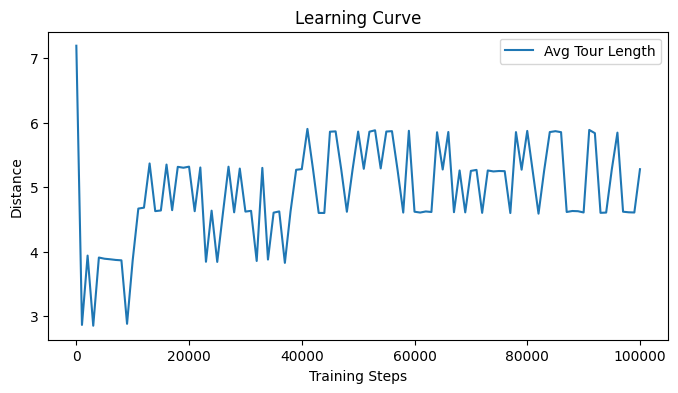

In [10]:
# %% [markdown]
# ## Plot Learning Curve

plt.figure(figsize=(8, 4))
plt.plot(steps, dist_log, label="Avg Tour Length")
plt.xlabel("Training Steps")
plt.ylabel("Distance")
plt.title("Learning Curve")
plt.legend()
plt.show()
